### Modification of Debiased Algorithm

In this section, we modify an existing debiasing algorithm to enhance its effectiveness. Our key change is the introduction of batch-wise input processing. This modification allows the model to learn the principal component at each layer by comparing across multiple samples. The objective is to identify a more accurate principal component that can effectively capture the variance in the gender subspace. The resulting principal components and embeddings are saved as `.npy` files for further analysis and use.


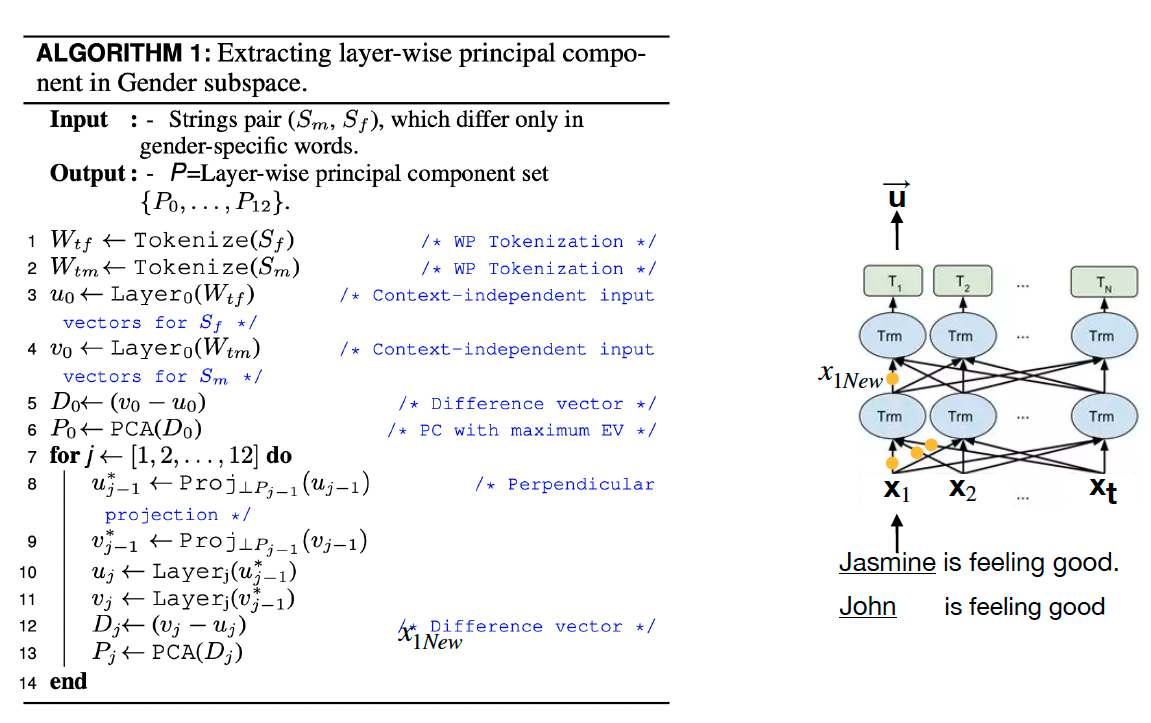

# Imports

In [1]:
from transformers import BertModel, BertConfig, BertTokenizer
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Custom BERT Model Class

This section introduces the `CustomBERTModel`, a specialized class inheriting from `BertModel`. The primary modification is in the `forward` method, enabling layer-wise embedding adjustment. The method calculates the difference between male and female embeddings and applies Principal Component Analysis (PCA) to identify and subtract the principal component, achieving debiasing at each layer. This process generates arrays of debiased embeddings for both genders and the principal components, enhancing our model's ability to mitigate gender bias effectively.


In [2]:
class CustomBERTModel(BertModel):
    """
    A custom BERT model class that modifies the forward method for layer-wise embedding adjustment.

    Inputs:
        input_ids_f: Tensor of input IDs for female examples.
        input_ids_m: Tensor of input IDs for male examples.
        attention_mask_f: Optional tensor representing the attention mask for female examples.
        attention_mask_m: Optional tensor representing the attention mask for male examples.

    Outputs:
        A tuple containing:
        - debiased_embeddings_f_np: Numpy array of debiased embeddings for female examples.
        - debiased_embeddings_m_np: Numpy array of debiased embeddings for male examples.
        - principal_components_np: Numpy array of principal components identified in each layer.

    Description:
        This method processes input embeddings for female and male examples through the BERT model layers,
        applying PCA to identify and subtract the principal bias component at each layer, resulting in 
        debiased embeddings for both genders.
    """
    def __init__(self, config):
        super().__init__(config)

    def forward(self, input_ids_f, input_ids_m, attention_mask_f=None, attention_mask_m=None):
        """
        Custom forward method for debiasing embeddings at each layer of the BERT model.

        Inputs:
            input_ids_f: Tensor of input IDs for female examples.
            input_ids_m: Tensor of input IDs for male examples.
            attention_mask_f: Optional tensor representing the attention mask for female examples.
            attention_mask_m: Optional tensor representing the attention mask for male examples.

        Outputs:
            A tuple containing:
            - debiased_embeddings_f_np: Numpy array of debiased embeddings for female examples.
            - debiased_embeddings_m_np: Numpy array of debiased embeddings for male examples.
            - principal_components_np: Numpy array of principal components identified in each layer.

        Description:
            Processes input embeddings for female and male examples through the BERT model layers,
            applying PCA to identify and subtract the principal bias component at each layer, resulting in 
            debiased embeddings for both genders.
        """
        # Initialize lists to store the principal components and debiased embeddings
        principal_components = []
        debiased_embeddings_f = []
        debiased_embeddings_m = []

        # Compute the initial embeddings for female and male inputs
        embedding_output_f = self.embeddings(input_ids=input_ids_f)
        embedding_output_m = self.embeddings(input_ids=input_ids_m)

        # Calculate the difference vector between male and female embeddings
        difference_vector = embedding_output_m - embedding_output_f
        # Use PCA to find the principal component that captures the bias
        pca = PCA(n_components=1)
        pca.fit(difference_vector.view(-1, difference_vector.size(-1)).cpu().detach().numpy())
        principal_component = pca.components_[0]

        # Store the initial principal component and embeddings
        principal_components.append(principal_component)
        debiased_embeddings_f.append(embedding_output_f)
        debiased_embeddings_m.append(embedding_output_m)

        # Prepare for processing through BERT layers
        hidden_states_f = embedding_output_f
        hidden_states_m = embedding_output_m

        # Apply attention masks and scale for BERT processing
        attention_mask_f = attention_mask_f.unsqueeze(1).unsqueeze(2)
        attention_mask_m = attention_mask_m.unsqueeze(1).unsqueeze(2)
        attention_mask_f = (1.0 - attention_mask_f) * -10000.0
        attention_mask_m = (1.0 - attention_mask_m) * -10000.0

        # Iterate through each layer of the BERT model
        for i, layer_module in enumerate(self.encoder.layer):
            # Process female and male embeddings through the current BERT layer
            layer_output_f = layer_module(hidden_states_f, attention_mask=attention_mask_f)
            layer_output_m = layer_module(hidden_states_m, attention_mask=attention_mask_m)

            # Update hidden states after layer processing
            hidden_states_f = layer_output_f[0]
            hidden_states_m = layer_output_m[0]

            # Compute difference vector for the current layer
            difference_vector = hidden_states_m - hidden_states_f

            # Recalculate the principal component for the current layer
            pca = PCA(n_components=1)
            pca.fit(difference_vector.view(-1, difference_vector.size(-1)).cpu().detach().numpy())
            principal_component = pca.components_[0]
            principal_components.append(principal_component)

            # Project the difference vector onto the principal component to adjust embeddings
            projection = difference_vector @ torch.tensor(principal_component).float().unsqueeze(-1).to(hidden_states_f.device)
            hidden_states_f -= projection
            hidden_states_m -= projection

            # Store debiased embeddings after adjustment
            debiased_embeddings_f.append(hidden_states_f)
            debiased_embeddings_m.append(hidden_states_m)

        # Convert the lists of tensors to numpy arrays for saving or further processing
        debiased_embeddings_f_np = np.stack([tensor.cpu().detach().numpy() for tensor in debiased_embeddings_f])
        debiased_embeddings_m_np = np.stack([tensor.cpu().detach().numpy() for tensor in debiased_embeddings_m])
        principal_components_np = np.array(principal_components)

        return debiased_embeddings_f_np, debiased_embeddings_m_np, principal_components_np

### Initialization of Tokenizer and Custom BERT Model

This section initializes the tokenizer and configures the BERT model using the `distilbert-base-uncased` version. We then instantiate our `CustomBERTModel` with this configuration, preparing it for the subsequent debiasing process.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
config = BertConfig.from_pretrained('distilbert-base-uncased')
model = CustomBERTModel(config)

### Generating Gender-Differentiated Sentence Pairs

In this section, we create sentence pairs that differ only in the gender of the subject, using a variety of professions to ensure a wide coverage. Each profession is prefixed with "He is a" or "She is a" to generate male and female sentence versions, respectively. These sentences are then tokenized and converted into input IDs and attention masks for further processing. This approach helps in isolating gender-related differences in the embeddings produced by the BERT model.


In [4]:
professions = [
    "doctor", "lawyer", "engineer", "nurse", "teacher",
    "scientist", "chef", "architect", "pharmacist", "therapist",
    "accountant", "veterinarian", "electrician", "plumber", "pilot",
    "mechanic", "artist", "musician", "writer", "journalist",
    "firefighter", "police officer", "paramedic", "dentist", "optometrist"
]

sentences_f = [f"She is a {profession}." for profession in professions]
sentences_m = [f"He is a {profession}." for profession in professions]

# Tokenize sentences to create a batch
input_ids_f = []
input_ids_m = []
attention_mask_f = []
attention_mask_m = []

for sentence_f, sentence_m in zip(sentences_f, sentences_m):
    encoded_pair_f = tokenizer(sentence_f, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    encoded_pair_m = tokenizer(sentence_m, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

    input_ids_f.append(encoded_pair_f['input_ids'])
    input_ids_m.append(encoded_pair_m['input_ids'])
    attention_mask_f.append(encoded_pair_f['attention_mask'])
    attention_mask_m.append(encoded_pair_m['attention_mask'])

# Stack the tensors to create batches
input_ids_f = torch.cat(input_ids_f, dim=0)
input_ids_m = torch.cat(input_ids_m, dim=0)
attention_mask_f = torch.cat(attention_mask_f, dim=0)
attention_mask_m = torch.cat(attention_mask_m, dim=0)

### Debiasing and Computing Layer-Wise Principal Components

This section involves executing the debiasing process through our `CustomBERTModel`. The model takes as input the tokenized sentence pairs (female and male versions) along with their attention masks. It outputs debiased embeddings for both genders and the principal components computed at each layer of the model. These outputs are then saved as `.npy` files for subsequent analysis and validation of the debiasing process.


In [5]:
debiased_embeddings_f, debiased_embeddings_m, principal_components = model(input_ids_f, input_ids_m,attention_mask_f,attention_mask_m)
# Save the embeddings to a file
np.save('debiased_embeddings_f.npy', debiased_embeddings_f)
np.save('debiased_embeddings_m.npy', debiased_embeddings_m)
np.save('principal_components.npy', principal_components)

# Testing debiasing

### Generating original bert embeddings

This section generates the original embeddings using a pre-trained BERT model. These embeddings represent the baseline gender-related information present in the text before applying our debiasing process. The embeddings for female and male sentence pairs are obtained and concatenated, then saved for further comparison.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
original_bert_model = BertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True)

# Get original embeddings from the BERT model
with torch.no_grad():
    outputs_f = original_bert_model(input_ids_f, attention_mask=attention_mask_f)
    outputs_m = original_bert_model(input_ids_m, attention_mask=attention_mask_m)
    original_embeddings_f = outputs_f.last_hidden_state
    original_embeddings_m = outputs_m.last_hidden_state

embeddings_original = torch.cat((original_embeddings_f, original_embeddings_m), dim=0)
gender_labels = torch.cat((torch.zeros(original_embeddings_f.size(0)), torch.ones(original_embeddings_m.size(0))), dim=0)
np.save('embeddings_original.npy', embeddings_original)

### Training a logistic regression to predict gender based on the embedding

We employ a logistic regression model to quantify the gender bias in the original embeddings. The model is trained to predict the gender associated with each embedding, and its accuracy serves as a benchmark to assess the effectiveness of our debiasing technique.


In [8]:
embeddings_original_np = np.load('embeddings_original.npy')

X_flattened = embeddings_original_np.reshape(embeddings_original_np.shape[0], -1)
gender_labels_np = gender_labels

X_train, X_test, y_train, y_test = train_test_split(X_flattened, gender_labels_np, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

predictions_before = log_reg.predict(X_test)
accuracy_before = accuracy_score(y_test, predictions_before)

print(f'Accuracy: {accuracy_before}')

Accuracy: 1.0


### Testing Debiasing effectiveness agaisnt the gender classification model

In this part, we evaluate the debiasing's success by applying the logistic regression model to the debiased embeddings. A significant drop in prediction accuracy would indicate that the debiasing process has effectively mitigated the gender bias in the embeddings.


In [9]:
embeddings_original_np = np.load('embeddings_original.npy')
debiased_embeddings_f = np.load('debiased_embeddings_f.npy')[-1]
debiased_embeddings_m = np.load('debiased_embeddings_m.npy')[-1]

embeddings_debiased = np.concatenate((debiased_embeddings_f, debiased_embeddings_m), axis=0)
X_debiased_flattened = embeddings_debiased.reshape(embeddings_debiased.shape[0], -1)

predictions_after = log_reg.predict(X_debiased_flattened)
accuracy_after = accuracy_score(gender_labels_np, predictions_after)

print(f"Accuracy before debiasing: {accuracy_before}")
print(f"Accuracy after debiasing: {accuracy_after}")

Accuracy before debiasing: 1.0
Accuracy after debiasing: 0.48


### Conclusions

The decreased accuracy of the logistic regression model in predicting gender from the debiased embeddings suggests that our debiasing efforts have been fruitful. Further examination of the principal components can provide insight into the gender subspace's representation across the layers of the BERT model.